❗ Оставлены рекомендации ревьюера

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Задачи**
1. Загрузить и подготовить данные.
2. Обучить разные модели. Для каждой попробовать различные гиперпараметры.
3. Проанализировать скорость работы и качество моделей.

## Подготовка данных

In [ ]:
import pandas as pd
import sklearn
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [ ]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('C:\\Users\\HARD_REBOOT\\Downloads\\autos.csv')

In [ ]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


**Признаки**

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

**Целевой признак**  
       
   Price — цена (евро)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
df.describe(include='object')

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


In [ ]:
df['DateCrawled'].max()

'2016-04-07 14:36:58'

1. Есть пропуски в типах кузова, мощности, моделях автомобиля, типах коробки передач, типе топлива, наличии ремонта. Вероятно они появились потому, что продавцы не знали или забыли указать информацию.
2. Есть неверные типы данных: даты в формате object.
3. В данных точно есть аномалии, например, в годах регистрации автомобиля минимальный год 1000, а максимальный 9999, чего быть не модет.
4. Ещё можно заметить, что количество фотографий автомобиля везде нулевое. Эти данные мы не сможем восстановить на основе имеющихся, поэтому этот столбец можно вообще удалить.
5. Названия столбцов написаны неудобно, переименуем.
6. Не все признаки годятся для предсказания стоимости автомобиля, от каких-то можем избавиться вместе со столбцом с фотографиями машин.

Начнём с переименовывания и удаления признаков, возможно, что-то из описанных пунктов параллельно отпадёт

In [ ]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [ ]:
df.set_axis(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'not_repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'],
            axis='columns' ,inplace=True)


df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Кроме количества фотографий удалим ещё эти признаки, которые точно не влияют на цену:
    
1. Почтовый индекс владельца
2. Дата скачивания анкеты из базы
3. Дата создания анкеты
4. Дата последней активности пользователя
5. Месяц регистрации автомобиля я бы тоже удалила, т.к. обычно смотрят на год регистрации при купли-продаже

In [ ]:
df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'],
        axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   not_repaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Параллельно мы избавились от дат, которые были записаны как object.  
Дальше займемся пропусками, они остались в признаках `vehicle_type`, `gearbox`, `model`, `fuel_type`, `not_repaired`
  
Посмотрим на процентное соотношение

In [ ]:
(df.isna().sum() / df.shape[0] * 100).round(2).sort_values(ascending=False)

not_repaired         20.08
vehicle_type         10.58
fuel_type             9.28
gearbox               5.60
model                 5.56
price                 0.00
registration_year     0.00
power                 0.00
kilometer             0.00
brand                 0.00
dtype: float64

От 5 до 20%. От пропусков в моделях мы избавимся, так как заполнить их грамотно на основании имеющихся данных не получится, а остальные заполним.

In [ ]:
df.dropna(subset=['model'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334664 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              334664 non-null  int64 
 1   vehicle_type       304002 non-null  object
 2   registration_year  334664 non-null  int64 
 3   gearbox            318962 non-null  object
 4   power              334664 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          334664 non-null  int64 
 7   fuel_type          308932 non-null  object
 8   brand              334664 non-null  object
 9   not_repaired       272564 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.1+ MB


Заполнять пропуски в признаках `fuel_type`, `power`, `vehicle_type` будем опираясь на бренд и модель машины. Если соответствий не найдётся, то пропуски заменятся на `other`

In [ ]:
df['vehicle_type'] = (df.groupby(['brand','model'])['vehicle_type'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "other"))))

df['vehicle_type'].value_counts()

sedan          100773
small           85609
wagon           66537
bus             31553
convertible     19591
coupe           15865
suv             11907
other            2829
Name: vehicle_type, dtype: int64

In [ ]:
df['fuel_type'] = (df.groupby(['brand','model'])['fuel_type'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "other"))))

df['fuel_type'].value_counts()

petrol      227995
gasoline    100756
lpg           4962
cng            544
hybrid         208
other          133
electric        66
Name: fuel_type, dtype: int64

Удивилась, увидев слово газолин, потому что на работе в керше читала, что смесь бензина и газолина — это чуть ли не мошенничество, которое удешевляет топливо и убивает двигатели современных автомобилей, потому что не всякий движок справляется с газолином в принципе.  
  
Загуглила в чём разница понятий petrol и gasoline в английском языке и оказалось, что дело только в диалектах, одно слово используют британцы, другое американцы. И это, и то бензин. [Пруф](https://www.quora.com/What-is-the-difference-between-gasoline-and-petrol)
  
Так что будем считать это неявным дубликатом (в признаке изначально были пропуски, поэтому буду считать, что это поле заполнялось вручную продавцами) и дальше при обработке дублей поменяем на `petrol`

In [ ]:
df['gearbox'] = (df.groupby(['brand','model'])['gearbox'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "other"))))

df['gearbox'].value_counts()

manual    269676
auto       64988
Name: gearbox, dtype: int64

In [ ]:
df.isna().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
fuel_type                0
brand                    0
not_repaired         62100
dtype: int64

Пропуски в последнем признаке заполню просто на `unknown`

In [ ]:
df['not_repaired'].fillna('unknown', inplace=True)

df['not_repaired'].value_counts()

no         238855
unknown     62100
yes         33709
Name: not_repaired, dtype: int64

In [ ]:
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
not_repaired         0
dtype: int64

Теперь перейдём к дубликатам. Один неявный дубликат мы уже нашли, поменяем `gazoline` сразу на `petrol`

In [ ]:
df.loc[df['fuel_type'] == 'gazoline', 'fuel_type'] = 'petrol'

df['fuel_type'].value_counts()

petrol      227995
gasoline    100756
lpg           4962
cng            544
hybrid         208
other          133
electric        66
Name: fuel_type, dtype: int64

In [ ]:
df.duplicated().sum()

47470

In [ ]:
df = df.drop_duplicates().reset_index(drop = True)
df.duplicated().sum()

0

Теперь избавимся от аномальных значений

In [ ]:
#функция для отрисовки гистограмм, лимиты и корзины буду подбирать вручную к каждой

def histogram(df, column, title,
                       figsize=(15,10),
                       xlabel='', ylabel='', kde=False,
                       bins=None, xticks=0, xlim=None, ylim=None):
        plt.figure(figsize=figsize)

        ax = sns.distplot(df[column], kde=kde, bins=bins)

        if (xlim != None):
            plt.xlim(xlim)
        if (ylim != None):
            plt.ylim(ylim)

        ax.set(xlabel=xlabel, ylabel=ylabel, title=title)

        if xticks != 0:
            ax.set(xticks=xticks)


In [ ]:
df.describe()

,price,registration_year,power,kilometer
count,287194.000000,287194.000000,287194.000000,287194.000000
mean,4614.935643,2004.086238,112.858764,127305.793297
std,4593.288899,74.191536,197.372862,38018.499861
min,0.000000,1000.000000,0.000000,5000.000000
25%,1199.000000,1999.000000,72.000000,125000.000000
50%,2950.000000,2003.000000,105.000000,150000.000000
75%,6700.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


**Год регистрации**

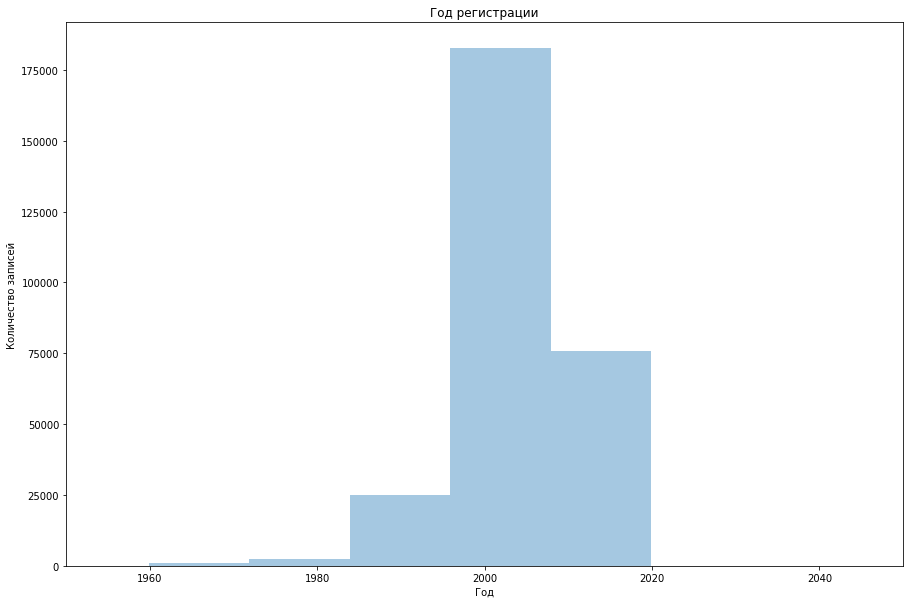

In [ ]:
histogram(df, 'registration_year', 'Год регистрации', xlabel='Год', ylabel='Количество записей', xlim=(1950, 2050), bins=750)

Отсечём значения раньше 1960 года и позже 2016 года, так как данные из базы были выгружены в 2016 году

In [ ]:
df = df.query('registration_year >= 1960 and registration_year <= 2016')

df.shape

(275636, 10)

**Цена**

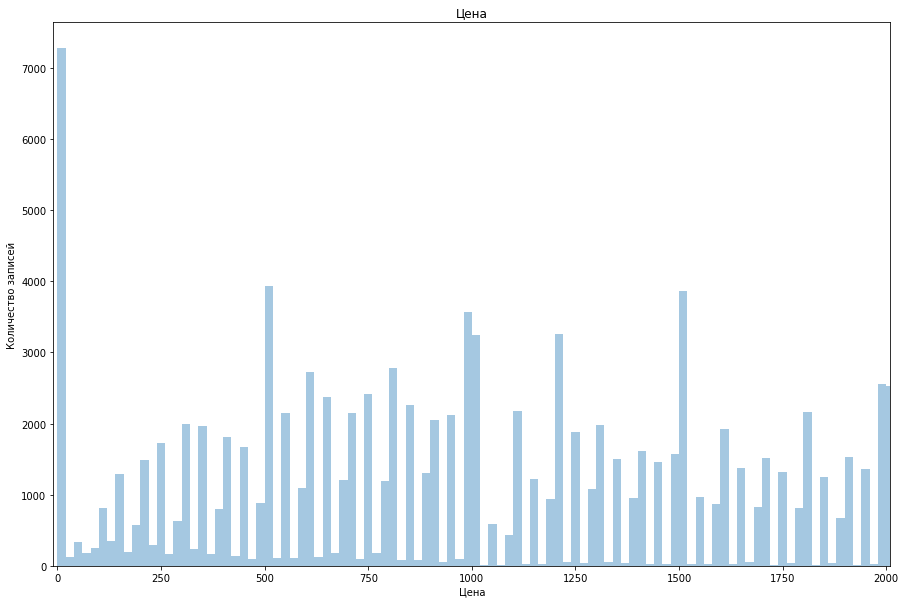

In [ ]:
histogram(df, 'price', 'Цена', xlabel='Цена', ylabel='Количество записей', xlim=(-10, 2010), bins=1000)

На гистограмме очень большое количество нулевых значений, я бы их не удаляла, а заменила бы медианными значениями по модели автомобиля.

In [ ]:
price_meds = df.pivot_table(index='model', values='price', aggfunc=['median', 'count'])
price_meds.columns = ['median', 'count']
price_meds

,median,count
model,,
100,1100.0,372
145,500.0,44
147,1950.0,491
156,1200.0,555
159,6499.5,192
...,...,...
yaris,3300.0,889
yeti,12945.0,156
ypsilon,925.0,178


In [ ]:
for model in price_meds.index:
    df.loc[(df['price'] == 0) & (df['model'] == model), 'price'] = price_meds.loc[model, 'median']

In [ ]:
df['price'].describe(percentiles=[.05, .1, .15, .25, .5, .75, .95])

count    275636.000000
mean       4739.235735
std        4587.446724
min           1.000000
5%          380.000000
10%         600.000000
15%         800.000000
25%        1290.000000
50%        3000.000000
75%        6850.000000
95%       14999.000000
max       20000.000000
Name: price, dtype: float64

Для профилактики слишком маленьких значений ограничим распределение 5 перцентилем

In [ ]:
df = df.query('price >= 380')

In [ ]:
df.shape

(261913, 10)

**Мощность**

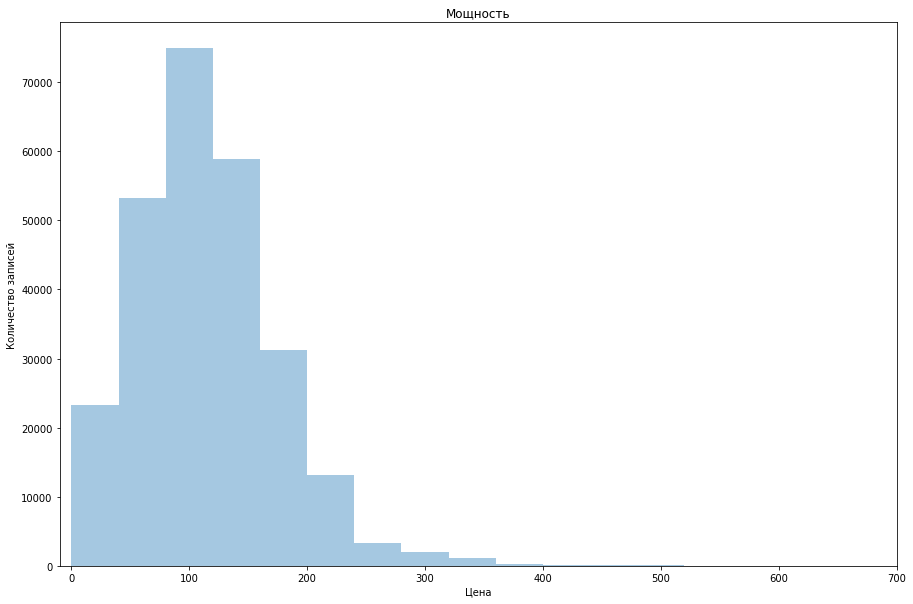

In [ ]:
histogram(df, 'power', 'Мощность', xlabel='Цена', ylabel='Количество записей', xlim=(-10, 700), bins=500)

Здесь тоже есть как нулевые, так и слишком большие значения. За верхнюю границу возьмём 1000 л.с., т.к. автомобили мощностью выше это уже редкость: или это спорткары или какие-нибудь самосвалы

In [ ]:
df = df.query('power > 0 and power <= 1000')

df.shape

(239227, 10)

In [ ]:
df['power'].describe(percentiles=[.05, .1, .15, .25, .5, .75, .95])

count    239227.000000
mean        123.587985
std          54.654369
min           1.000000
5%           58.000000
10%          60.000000
15%          72.000000
25%          84.000000
50%         116.000000
75%         150.000000
95%         224.000000
max        1000.000000
Name: power, dtype: float64

Уберём значения, которые меньше 58

In [ ]:
df = df.query('power >= 58')

df.shape

(227478, 10)

## Обучение моделей

Для кодирования категориальных признаков воспользуемся техникой прямого кодирования (OHE), чтобы преобразовать категориальные признаки в численные. Также проставим аргумент drop_first = True, чтобы один из столбцов фиктивных переменных для каждого признака был сброшен(это нужно чтобы не угодить в так называемую дамми-ловушку, когда фиктивных признаков слишком много).

In [ ]:
df = pd.get_dummies(df, drop_first=True)

df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227478 entries, 1 to 287193
Columns: 305 entries, price to not_repaired_yes
dtypes: float64(1), int64(3), uint8(301)
memory usage: 74.0 MB


,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
1,9800.0,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,1500.0,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,3600.0,2008,69,90000,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,650.0,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,2200.0,2004,109,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,14500.0,2014,125,30000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,999.0,1998,101,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
9,2000.0,2004,105,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2799.0,2005,140,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
11,999.0,1995,115,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


<font color="brown">⚠️ Комментарий ревьювера   
Можно использовать OHE. Крайне желательно указывать, какие столбцы ты кодируешь</font>


Разделим датафрейм на признаки и целевой признак.

In [ ]:
target = df['price']
features = df.drop('price', axis=1)

Дальше разделим данные с помощью train_test_split() на выборки: обучающая+валидационная и тестовая. Потом одну из выборки снова разделим на обучающую и валидационную. У нас получится соотношение 3:1:1

In [ ]:
df_train_first, df_test = train_test_split(df, test_size=0.2, random_state=12345)

In [ ]:
df_train, df_valid = train_test_split(df_train_first, test_size=0.25, random_state=12345)

In [ ]:
features_train = df_train.drop(['price'], axis=1)
target_train = df_train['price']

features_valid = df_valid.drop(['price'], axis=1)
target_valid = df_valid['price']

features_test = df_test.drop(['price'], axis=1)
target_test = df_test['price']

<font color="brown">⚠️ Комментарий ревьювера   
Хорошо бы вывести размерность данных</font>


Масштабируем признаки

In [ ]:
columns = ['registration_year','power','kilometer']


scaler = StandardScaler()
scaler.fit(features_train[columns])

features_train[columns] = scaler.transform(features_train[columns])
features_valid[columns] = scaler.transform(features_valid[columns])
features_test[columns] = scaler.transform(features_test[columns])



**Модель LightGBM**

Будем использовать LGBMRegressor. Напишем функцию, которая переберёт гиперпараметры и запишет те, с которыми RMSE принимает наименьшее значение

RMSE моделей должно быть меньше 2500

In [ ]:
def lgbm_f(features_train, target_train, features_valid, target_valid):
    for depth in range(3, 13, 5):
        best_rmse = 2500
        best_fit_time = 0
        best_est = 0
        best_parameters = ''

        for est in range(50, 110, 50):
            lgbm = LGBMRegressor(max_depth=depth, n_estimators=est, random_state=12345)

            start = time.time()
            lgbm.fit(features_train, target_train)
            fit_time = time.time() - start
            predictions = lgbm.predict(features_valid)

            rmse = mean_squared_error(target_valid, predictions)**0.5
            #print('Глубина', depth, '- оценщиков' , est, '- RMSE =', rmse)

            if best_rmse > rmse:
                best_rmse = rmse
                best_est = est
                best_fit_time = fit_time
                best_parameters = 'Глубина', depth, 'Оценщиков', est

        print('Наилучший результат при', depth, 'глубине, при', est, 'оценщиках:', best_rmse, 'Время обучения:', best_fit_time, '\n')

In [ ]:
%%time

lgbm_f(features_train, target_train, features_valid, target_valid)

Наилучший результат при 3 глубине, при 100 оценщиках: 1922.178405829469 Время обучения: 19.306243419647217 

Наилучший результат при 8 глубине, при 100 оценщиках: 1725.625059348515 Время обучения: 4.001062393188477 

CPU times: user 34.7 s, sys: 1.28 s, total: 35.9 s
Wall time: 36.4 s




<font color="brown">⚠️ Комментарий ревьювера   
В LightGBM и CatBoost также можно использовать встроенное кодирование данных с помощью параметра categorical_feature и переводом данный в тип category, иногда это дает лучший результат :)</font>


<font color="brown">⚠️ Комментарий ревьювера     
Желательно сохранять полученные данные, в том числе время обучения и предсказания, в список или словарь :)</font>


**Линейная регрессия**

Второй моделью обучим линейную регрессию и проверим на валидационной выборке

In [ ]:
%%time

lr = LinearRegression()
score = cross_val_score(lr, features_train, target_train, cv=5, scoring='neg_mean_squared_error').mean()
start = time.time()
lr.fit(features_train, target_train)
fit_time = time.time() - start

predictions = lr.predict(features_valid)
print('RMSE:', mean_squared_error(target_valid, predictions)**0.5, 'Время обучения:', fit_time)


RMSE: 2610.3636506038765 Время обучения: 30.01925039291382
CPU times: user 49.6 s, sys: 29.5 s, total: 1min 19s
Wall time: 1min 19s


**CatBoost**

Для этой модели взяла функцию для LightGBM и поменяла её под нужные параметры

In [ ]:
def cat_b(features_train, target_train, features_valid, target_valid):

    for depth in range(3, 13, 5):
        best_rmse = 2500
        best_iterations = 0
        best_fit_time = 0
        best_parameters = ''

        for iteration in range(50, 150, 50):
            catboost = CatBoostRegressor(depth=depth, iterations=iteration, random_state=12345)
            start = time.time()
            catboost.fit(features_train, target_train)
            fit_time = time.time() - start
            predictions = catboost.predict(features_valid)

            rmse = mean_squared_error(target_valid, predictions)**0.5


            if best_rmse > rmse:
                best_rmse = rmse
                best_iterations = iteration
                best_fit_time = fit_time
                best_parameters = 'Глубина', depth, 'Итераций', iteration

        print('Наилучший результат при', depth, 'глубине, при', best_iterations, 'итерациях:', best_rmse, 'Время обучения:', best_fit_time, '\n')

In [ ]:
%%time

cat_b(features_train, target_train, features_valid, target_valid)

Learning rate set to 0.5
0:	learn: 3600.6994608	total: 65.1ms	remaining: 3.19s
1:	learn: 3047.4315084	total: 78.8ms	remaining: 1.89s
2:	learn: 2737.3044516	total: 91.1ms	remaining: 1.43s
3:	learn: 2590.1003710	total: 103ms	remaining: 1.19s
4:	learn: 2505.7226061	total: 120ms	remaining: 1.08s
5:	learn: 2429.6032245	total: 138ms	remaining: 1.01s
6:	learn: 2349.4745909	total: 152ms	remaining: 935ms
7:	learn: 2308.8653274	total: 165ms	remaining: 869ms
8:	learn: 2262.6260066	total: 179ms	remaining: 815ms
9:	learn: 2234.0244975	total: 193ms	remaining: 772ms
10:	learn: 2207.3875812	total: 209ms	remaining: 739ms
11:	learn: 2187.1770564	total: 221ms	remaining: 700ms
12:	learn: 2168.6645232	total: 240ms	remaining: 682ms
13:	learn: 2154.0339665	total: 253ms	remaining: 650ms
14:	learn: 2138.1079084	total: 266ms	remaining: 621ms
15:	learn: 2127.3768819	total: 277ms	remaining: 590ms
16:	learn: 2109.5119951	total: 289ms	remaining: 561ms
17:	learn: 2100.1680591	total: 300ms	remaining: 534ms
18:	learn:

Learning rate set to 0.5
0:	learn: 3237.0929034	total: 29.2ms	remaining: 1.43s
1:	learn: 2601.7837460	total: 52.2ms	remaining: 1.25s
2:	learn: 2303.9821511	total: 73.8ms	remaining: 1.16s
3:	learn: 2149.9076250	total: 95.7ms	remaining: 1.1s
4:	learn: 2066.7772592	total: 124ms	remaining: 1.11s
5:	learn: 2004.0755271	total: 144ms	remaining: 1.06s
6:	learn: 1970.8827648	total: 165ms	remaining: 1.01s
7:	learn: 1943.9194662	total: 184ms	remaining: 966ms
8:	learn: 1921.8769063	total: 212ms	remaining: 966ms
9:	learn: 1896.6138252	total: 234ms	remaining: 936ms
10:	learn: 1879.4909772	total: 255ms	remaining: 903ms
11:	learn: 1866.6985294	total: 274ms	remaining: 869ms
12:	learn: 1858.3186239	total: 300ms	remaining: 853ms
13:	learn: 1846.9959394	total: 322ms	remaining: 828ms
14:	learn: 1838.9244973	total: 342ms	remaining: 797ms
15:	learn: 1831.9844270	total: 362ms	remaining: 769ms
16:	learn: 1818.2007588	total: 384ms	remaining: 744ms
17:	learn: 1814.0304505	total: 409ms	remaining: 728ms
18:	learn:

<font color="brown">⚠️ Комментарий ревьювера     
Желательно сделать поиск лучших параметров с помощью цикла или GridSearchCV или RandomSearchCV или HalvingGridSearchCV:)</font>


In [ ]:
results = {'model': ['Линейная регрессия', 'LightGBM','CatBoost'],
           'rmse': [2610, 1725, 1657],
           'time': ['30.1s','4.0s','3.5s']
          }
results = pd.DataFrame(data=results)
results

,model,rmse,time
0,Линейная регрессия,2610,30.1s
1,LightGBM,1725,4.0s
2,CatBoost,1657,3.5s


**Вывод**

На валидационной выборке гораздо быстрее себя показала модель CatBoost и она показала лучший результат метрики (1657), на втором месте по качеству LightGBM (1725), а модель линейной регрессии порог RMSE в 2500 не прошла, кроме того она оказалась самой медленной

## Анализ моделей

Проверим модели на тестовой выборке

In [ ]:
%%time

lgbm = LGBMRegressor(max_depth=8, n_estimators=100, random_state=12345)
lgbm.fit(features_train, target_train)
start = time.time()
predictions = lgbm.predict(features_test)
predict_time = time.time() - start

rmse = mean_squared_error(target_test, predictions)**0.5
print('RMSE =', rmse, 'Время предсказания:', predict_time)

RMSE = 1746.9085755846195 Время предсказания: 0.5116837024688721
CPU times: user 27.7 s, sys: 272 ms, total: 28 s
Wall time: 28.2 s


In [ ]:
%%time
lr = LinearRegression()
lr.fit(features_train, target_train)
start = time.time()
predictions = lr.predict(features_test)
predict_time = time.time() - start

rmse = mean_squared_error(target_test, predictions)**0.5
print('RMSE =', rmse, 'Время предсказания:', predict_time)

RMSE = 2640.391473753139 Время предсказания: 0.10240745544433594
CPU times: user 9.7 s, sys: 5.15 s, total: 14.9 s
Wall time: 14.9 s


In [ ]:
%%time
catboost = CatBoostRegressor(depth=8, iterations=100, random_state=12345)
catboost.fit(features_train, target_train)
start = time.time()
predictions = catboost.predict(features_test)
predict_time = time.time() - start

rmse = mean_squared_error(target_test, predictions)**0.5
print('RMSE =', rmse, 'Время предсказания:', predict_time)

Learning rate set to 0.5
0:	learn: 3237.0929034	total: 21.1ms	remaining: 2.09s
1:	learn: 2601.7837460	total: 42.2ms	remaining: 2.07s
2:	learn: 2303.9821511	total: 70.9ms	remaining: 2.29s
3:	learn: 2149.9076250	total: 91.1ms	remaining: 2.19s
4:	learn: 2066.7772592	total: 111ms	remaining: 2.11s
5:	learn: 2004.0755271	total: 131ms	remaining: 2.05s
6:	learn: 1970.8827648	total: 157ms	remaining: 2.08s
7:	learn: 1943.9194662	total: 177ms	remaining: 2.03s
8:	learn: 1921.8769063	total: 196ms	remaining: 1.98s
9:	learn: 1896.6138252	total: 218ms	remaining: 1.97s
10:	learn: 1879.4909772	total: 239ms	remaining: 1.93s
11:	learn: 1866.6985294	total: 268ms	remaining: 1.96s
12:	learn: 1858.3186239	total: 287ms	remaining: 1.92s
13:	learn: 1846.9959394	total: 306ms	remaining: 1.88s
14:	learn: 1838.9244973	total: 325ms	remaining: 1.84s
15:	learn: 1831.9844270	total: 350ms	remaining: 1.84s
16:	learn: 1818.2007588	total: 371ms	remaining: 1.81s
17:	learn: 1814.0304505	total: 389ms	remaining: 1.77s
18:	learn

## Вывод

In [ ]:
results = {'model': ['Линейная регрессия', 'LightGBM','CatBoost'],
           'rmse': [2640, 1746, 1675],
           'fit_time': ['30.1s','4.0s','3.5s'],
           'predict_time': ['14.9s','0.5s','0.04s']
          }
results = pd.DataFrame(data=results)
results

,model,rmse,fit_time,predict_time
0,Линейная регрессия,2640,30.1s,14.9s
1,LightGBM,1746,4.0s,0.5s
2,CatBoost,1675,3.5s,0.04s


1. Наиболее быстрой и качественной показала себя модель CatBoostRegressor. (время обучения 3.5 сек, время предсказания 0.04 сек и RMSE=1675)
2. На втором месте модель LGBMRegressor (время обучения 4 сек, время предсказания 0.5 сек и RSME=1746)
3. Самой долгой и некачественной у меня получилась модель линейной регрессии: она отработала за 12.8 сек и не смогла получить необходимый размер метрики ни на валидационной выборке, ни на тестовой (2734 вместо требуемых 2500)